In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [2]:
df = pd.read_csv('data/dataSentimen.csv')
df = df.head(1000)
df['sentimen'] = df['sentimen'].replace({
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral'
})
df

,cleaned_text,sentimen
0,body ev buat bauksit juga milik indonesia ketu...,netral
1,baterai rupa komponen utama ev indonesia milik...,netral
2,indonesia milik semua komponen bahan dasar bua...,netral
3,ev rupa tongkat indonesia jadi dominasi dunia ...,netral
4,hadir spkkamu juga jadi perhati tamutamu negar...,netral
...,...,...
995,bamsoet puji upaya pertamina migrasi kendara k...,netral
996,kepala bkpm negosiasi tesla jalan ada putus te...,netral
997,pertamina usaha negara milik nilai aset sangat...,netral
998,eng kembang kendara listrik bisa tunggu energi...,netral


In [3]:
# Bersihkan data kosong/null
df = df.dropna(subset=['cleaned_text', 'sentimen'])
df = df[df['cleaned_text'].str.strip() != ""]

# Cek panjang teks
df['text_length'] = df['cleaned_text'].str.len()
print(df['text_length'].describe())

count    1000.000000
mean      113.016000
std        53.407697
min        15.000000
25%        65.000000
50%       107.000000
75%       157.250000
max       239.000000
Name: text_length, dtype: float64


In [4]:
# Encode label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentimen'])

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [6]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
class BertLSTMData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

In [9]:
class BertBiLSTMAttentionClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim=128, num_classes=3):
        super(BertBiLSTMAttentionClassifier, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        context = self.attention(lstm_output)
        output = self.dropout(context)
        return self.fc(output)

In [10]:
train_dataset = BertLSTMData(train_texts, train_labels, tokenizer)
val_dataset = BertLSTMData(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertBiLSTMAttentionClassifier(bert_model).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
    val_acc = eval_model(model, val_loader)
    print(f"Train Loss: {train_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

Epoch 1/3


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Train Loss: 0.9046 | Validation Accuracy: 0.7950
Epoch 2/3


100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


Train Loss: 0.6900 | Validation Accuracy: 0.7950
Epoch 3/3


100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Train Loss: 0.6135 | Validation Accuracy: 0.7950


Confusion Matrix:
[[  0  16   0]
 [  0 159   0]
 [  0  25   0]]


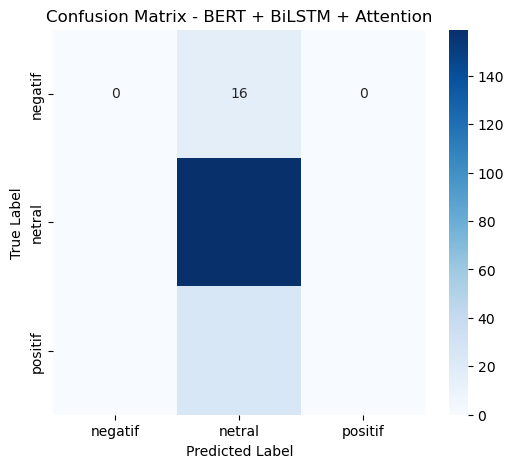

Classification Report:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        16
      netral       0.80      1.00      0.89       159
     positif       0.00      0.00      0.00        25

    accuracy                           0.80       200
   macro avg       0.27      0.33      0.30       200
weighted avg       0.63      0.80      0.70       200



c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [13]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BERT + BiLSTM + Attention')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))